In [1]:
import pandas as pd
data = pd.read_csv('./Updated_Mobile_Dataset.csv')

def map_to_cat(price):
    if price < 7500:
        return 'Low'
    elif 7500 <= price < 15000:
        return 'Medium'
    elif 15000 <= price < 30000:
        return 'High'
    elif price >= 30000:
        return 'Very high'

aug_model = data['Model'].copy()
aug_color = [None]*len(aug_model)
aug_price_category = [None]*len(aug_model)
for i,r in data.iterrows():
    aug_model[i] = str(aug_model[i]).replace(r['Company'], '').strip()
    aug_price_category[i] = map_to_cat(r['Price'])
    if (r['Model'].find(',') != -1) and (r['Model'].find('(') != -1):
        aug_color[i] = aug_model[i].split('(')[1].split(',')[0]
        aug_model[i] = aug_model[i].split('(')[0]

data['aug_model'] = aug_model
data['aug_color'] = aug_color
data['aug_price'] = aug_price_category

data = data.drop_duplicates().reset_index(drop=True)
data = data[data['Company'] != 'Nothing']
data['Company'] = data['Company'].str.capitalize()

data = data.dropna()
data['RamSize'] = data['RamSize'].apply(lambda e: e.split(' ')[0])
data['RomSize'] = data['RomSize'].apply(lambda e: e.split(' ')[0])
data = data[data['RomSize'] != 'Not']
data['RamSize'] = data['RamSize'].astype(float)
data['RomSize'] = data['RomSize'].astype(float)
data = data.rename(columns={ 'RamSize'      : 'RamSize (GB)',  
                             'RomSize'      : 'RomSize (GB)',
                             'TotalReviwes' : 'TotalReviews'
                           }).reset_index(drop=True)

data = data[(data['Price'] != 84999) & (data['Price'] != 59999)]

data.to_csv('augmented_dataset.csv', index=False)
data

,Model,Company,Price,Rating,No_of_ratings,TotalReviews,RamSize (GB),RomSize (GB),aug_model,aug_color,aug_price
0,"Infinix HOT 20 Play (Luna Blue, 64 GB)",Infinix,8199,4.3,505,52,4.0,64.0,HOT 20 Play,Luna Blue,Medium
1,"MOTOROLA e40 (Carbon Gray, 64 GB)",Motorola,7999,4.1,56085,5600,4.0,64.0,e40,Carbon Gray,Medium
2,"MOTOROLA e40 (Pink Clay, 64 GB)",Motorola,7999,4.1,56085,5600,4.0,64.0,e40,Pink Clay,Medium
3,"POCO C31 (Shadow Gray, 64 GB)",Poco,7499,4.3,183688,11185,4.0,64.0,C31,Shadow Gray,Low
4,"MOTOROLA G32 (Mineral Gray, 64 GB)",Motorola,9999,4.2,16249,1639,4.0,64.0,G32,Mineral Gray,Medium
...,...,...,...,...,...,...,...,...,...,...,...
525,"SAMSUNG M53 5G (Deep Ocean Blue, 128 GB)",Samsung,26999,4.0,167,13,8.0,128.0,M53 5G,Deep Ocean Blue,High
526,"OPPO A54 (Starry Blue, 64 GB)",Oppo,11949,4.4,10827,670,4.0,64.0,A54,Starry Blue,Medium
527,"LAVA Z2 (Flame Red, 32 GB)",Lava,7999,4.1,330,57,3.0,32.0,Z2,Flame Red,Medium
528,"POCO F1 (Rosso Red, 64 GB)",Poco,21999,4.5,244098,30034,6.0,64.0,F1,Rosso Red,High


In [2]:
cat_columns = ['Model', 'Company', 'aug_model', 'aug_color', 'aug_price']

from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

df_vals_only = data.drop(columns=cat_columns)
df_vals_only.to_csv('./vals_only.csv', index=False)
df_scaled = scale.fit_transform(df_vals_only)
df_scaled = pd.DataFrame(df_scaled) 
df_scaled.columns = [df_vals_only[:0]]

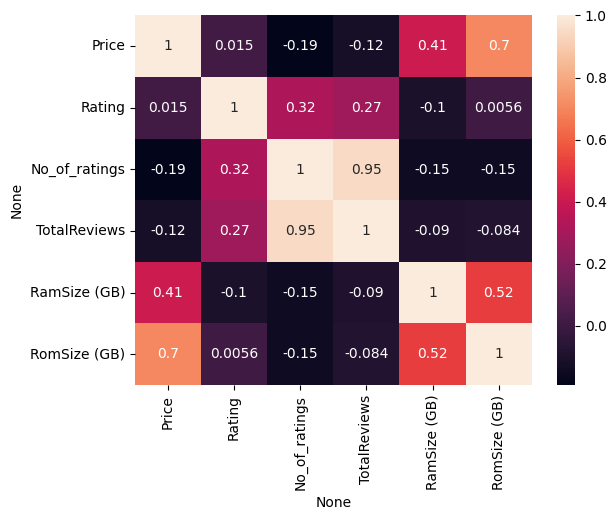

In [3]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_scaled.corr(), annot=True)
plt.show()

In [40]:
import plotly.express as px

df = data[(data['Price'] != 84999) & (data['Price'] != 59999)]

fig = px.box(data, y='Price', points='all')
fig.show()

PCA(n_components=2)


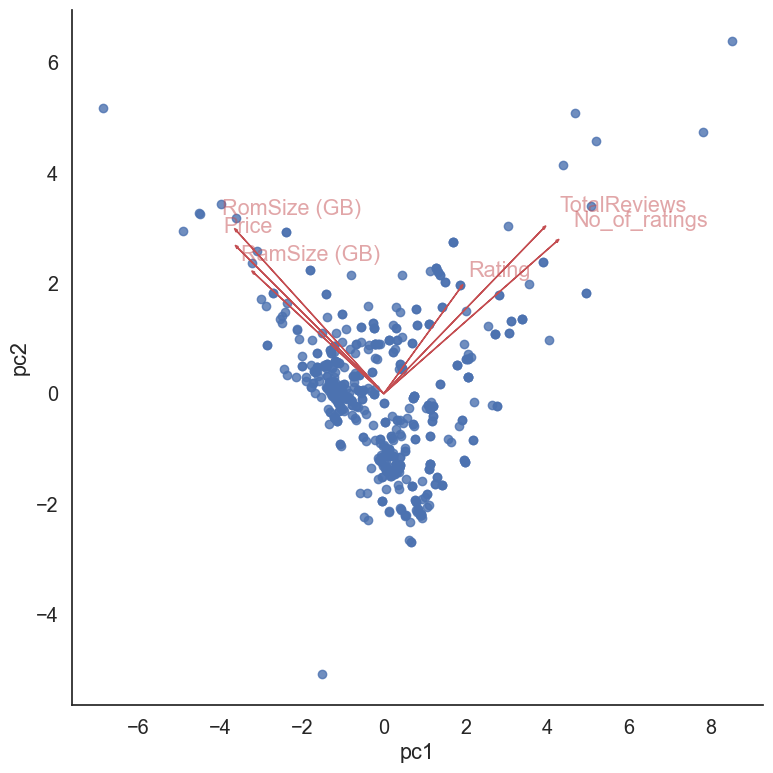

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(principal_components)
df_pca[cat_columns] = data[cat_columns].values

df_pca.columns = ['pc1', 'pc2'] + cat_columns

sns.set(style='white', color_codes=True, font_scale=1.3)
sns.lmplot(data=df_pca, x='pc1', y='pc2', fit_reg=False, height=8)

xvector = pca.components_[0]
yvector = pca.components_[1]

#print(dir(pca))
#print(pca.explained_variance_ratio_)
print(pca)

df = pd.DataFrame()
x,y,f = [],[],[]
for c,xx,yy in zip(df_vals_only.columns.values, xvector, yvector):
    f += [c]*2
    x += [0, xx]
    y += [0, yy]
    
df['Feature'] = f
df['x'] = x
df['y'] = y
df.to_csv('features.csv', index=False)

# value of the first two PCs, set the x, y axis boundary
xs = pca.transform(df_scaled)[:,0]
ys = pca.transform(df_scaled)[:,1]

for i in range(len(xvector)):
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.005, head_width=0.05)
    plt.text(xvector[i]*max(xs)*1.1, yvector[i]*max(ys)*1.1,
             list(df_vals_only.columns.values)[i], color='r', alpha=0.5)
    
df_pca.to_csv('pca.csv', index=False)

import sklearn.cluster as skc
kmeans_model = skc.KMeans(n_clusters=2)
kmeans_model.fit(df_scaled)
df_kmeans = data.copy()
df_kmeans['cluster_labels_kmeans'] = kmeans_model.labels_
df_kmeans.to_csv('kmeans.csv', index=False)

In [3]:
from sklearn.decomposition import PCA
import numpy as np

vals = []
for n in range(1, 5+1):
    pca = PCA(n_components=n)
    principal_components = pca.fit_transform(df_scaled)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    components = pd.DataFrame(pca.components_)
    components.columns = df_vals_only.columns
    vals.append(round(sum(pca.explained_variance_ratio_), 2))
    if n == 2:
        pca2 = pca
    
df = pd.DataFrame({ 'PCA Components' : [f'PC{n}' for n in list(range(1,5+1))], 
                    'Explained variance' : vals,
                    'pca.explained_variance_ratio_' : pca.explained_variance_ratio_})


loadings = pca2.components_.T * np.sqrt(pca2.explained_variance_)
loadings_df = pd.DataFrame(loadings, columns=[f'PC{n}' for n in list(range(1,2+1))])
loadings_df['Feature'] = df_vals_only.columns.tolist()
display(loadings_df)

df.to_csv('pca_variance.csv', index=False)
loadings_df.to_csv('pca_loadings.csv', index=False)

,PC1,PC2,Feature
0,-0.607949,0.564411,Price
1,0.337866,0.414374,Rating
2,0.797586,0.544285,No_of_ratings
3,0.745405,0.591842,TotalReviews
4,-0.574877,0.491640,RamSize (GB)
5,-0.624368,0.623854,RomSize (GB)
